In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Trin 1 - Collect data
Det data set vi har gjort brug af er tilgængeligt igennem kaggle challenge (https://www.kaggle.com/c/state-farm-distracted-driver-detection), hvor data er blevet stillet tilrådighed for os via en zip fil. Zip filen inderholder det train data vi skal træne på, og test data som vi skal bruge for at validere vores model mod challenge leaderboarded. Kaggle challengen er dog allerede overstået, så vi vil ikke kunne positionere os på deres leaderboard.

# Trin 2 - Data preparation
Det data vi fik fra zip filen ligger vi ved siden af denne notebook fil for at vi kan tilgå det via en relativ sti til projektet.

In [3]:
path = Path('imgs')
path.ls()

(#2) [Path('imgs/test'),Path('imgs/train')]

Vi fokusere i starten om at få fat i det data der er vores trænings data da vi først skal kunne træne vores model for at kunne validere det.

In [4]:
train = path/"train"
train.ls()

(#10) [Path('imgs/train/c0'),Path('imgs/train/c1'),Path('imgs/train/c2'),Path('imgs/train/c3'),Path('imgs/train/c4'),Path('imgs/train/c5'),Path('imgs/train/c6'),Path('imgs/train/c7'),Path('imgs/train/c8'),Path('imgs/train/c9')]

Vi verificere de billeder vi har fået for at sikre os, at billederne er i optimal tilstand før vores model arbejder med dem. Hvis der er billeder der er beskadet eller ikke er billeder, vil vi vi få disse fjernet.

In [5]:
failed = verify_images(get_image_files(train))
failed.map(Path.unlink)

(#0) []

Da vores model skal kunne multi kategorisere billederne har vi lavet en metode der tager input i form af stien til billedet, hvor vi så bruger parent_label til at få navnet på den folder billedet ligger i, og putter den i et nyt array for at sikre at MultiCategoryBlock kan læse det.

In [6]:
def get_y(p):
    return [parent_label(p)]

Vi lavede metoden get_dls med parameterne bs og size for at vi hurtigere kunne ændre på størrelsen af batch og billederne da vi skulle balancere hvor meget data vi kunne tillade at anvende før vi løb tør for det når vi skulle træne vores model.
Vi gør brug af RandomSplitter da det virkede optimalt til at splitte vores træningssæt ud mellem et trænings set og validerings sæt.

Vi sørger også for at billederne i vores dataloaders er af samme størrelse ved hjælp af at sætte item_tfms til Resize(size) hvor size bliver opgjort ved metode parameterne.
Vi bruger også en aug_transforms på vores batch_tfms for at modificere vores data så vores model kan tage højde for mindre forskelle med kamera position, og evt. brug af forskellige kamera lenser.

Vores get_dls retunere dataloaders som bruger train stien til at få fat i det data, den skal bruge for at lave dataloadersne. Grunden til vi sætter num_workers til at være 0 er for at vi kan træne vores model lokalt på Windows OS da det ellers vil give fejl hvor der mangler noget CUDA implementering der ikke er understøttet af CUDA til windows.

In [7]:
def get_dls(bs, size):
    dBlock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       get_items = get_image_files,
                       splitter = RandomSplitter(valid_pct = .2, seed = 42),
                       get_y = get_y,
                       item_tfms = Resize(size = size),
                       batch_tfms = aug_transforms(do_flip = False, max_warp = 0),
    )
    return dBlock.dataloaders(train, bs=bs, num_workers=0)

Vi sætter dls til at være resultatet af vores get_dls og tjekker vores træningssæt om vores data ser acceptabelt ud til modellen og for at vurdere om vi skal ændre den måde vi transformere vores data på.

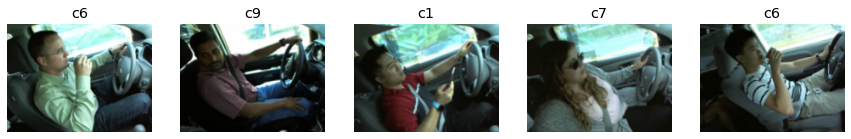

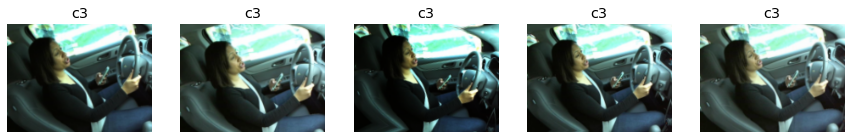

In [8]:
dls = get_dls(128, (128,171))
dls.train.show_batch(max_n=5, nrows=1)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

# Trin 3 - Choose model
Vi har valgt at bruge resnet 34, da det var den model der gav højst accuracy ud af dem vi testede. Et eksempel på en vi testede var resnet 50, for at se om flere lag kunne forbedre vores nøjagtighed, dog viste dette sig for at forringe vores nøjagtighed i alle scenarier vi testede på, der både inkluderede ændringer i vores træning og ændringer i vores transformation af data.

In [9]:
learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)

# Trin 4 - Train model
Vores træning består af 2 omgange af træning, den første træning beholder vi vores pretrained values på de dybe lag, for at tilpasse de nyeste tilføjede lag, den første træning bliver kørt med en relativt høj learning rate og få epochs da vi laver en længere træning bagefter.

Vores anden træning starter med at unfreeze vores dybe lag, for at lave finetuning af alle lagene med en variende learning rate
Dette gør at vores dybelag bliver tilpasset en lidt efter vores data, og de øverstelag får en hårdere træning

In [10]:
learn.fit_one_cycle(3, 3e-3)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.338472,0.076171,0.976517,02:52
1,0.069312,0.022118,0.993666,02:52
2,0.035294,0.016581,0.995450,02:52


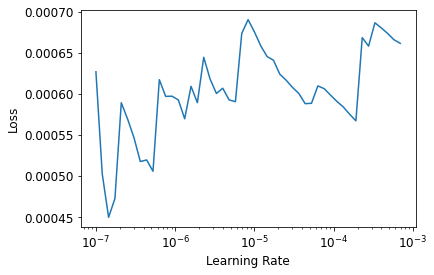

In [36]:
learn.unfreeze()
lr_minest, lr_steepest, lr_maxest = learn.lr_find()

In [40]:
lr_steepest

2.2908675418875646e-06

In [19]:
learn.export()

In [ ]:
learn = load_learner("export.pkl")
learn.cuda()

In [21]:
learn.fit_one_cycle(6, lr_max=slice(0.00014454397605732084,0.0003311311302240938))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.017846,0.010085,0.997145,03:00
1,0.012428,0.006575,0.998260,03:04
2,0.004399,0.002779,0.999353,03:06
3,0.002187,0.002789,0.999086,03:07
4,0.001060,0.001625,0.999554,03:14
5,0.000723,0.001446,0.999643,03:08


# Trin 5 - Evaluation
Vi prøver at lave vores predictions og tester op med vores validation set

# Trin 6 - Tuning
Vores main Tuning af vores model er vores variende learningrate efter vi unfreezer alle vores lag, med de min/max learningrate lr_find() metoden anbefaler os

In [22]:
preds,targs = learn.get_preds()

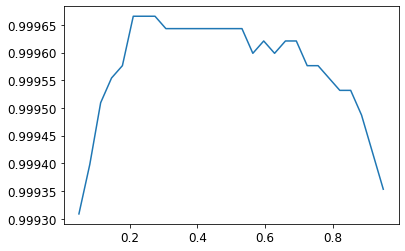

In [23]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

In [24]:
learn.validate()

(#2) [0.0014457161305472255,0.9996432662010193]

# Trin 7 - Prediction
Vores færdig trænet model bliver exportet og vi laver en submission.csv file til at få en score fra https://www.kaggle.com/

In [25]:
learn.export()

In [ ]:
learn = load_learner("export.pkl")

Add some CAM stuff

In [ ]:
learn.cuda()

Do testy test on stuff

In [26]:
test = path/"test"

In [27]:
test.ls()

(#79726) [Path('imgs/test/img_1.jpg'),Path('imgs/test/img_10.jpg'),Path('imgs/test/img_100.jpg'),Path('imgs/test/img_1000.jpg'),Path('imgs/test/img_100000.jpg'),Path('imgs/test/img_100001.jpg'),Path('imgs/test/img_100002.jpg'),Path('imgs/test/img_100003.jpg'),Path('imgs/test/img_100004.jpg'),Path('imgs/test/img_100005.jpg')...]

In [28]:
test_gif = get_image_files(test)
test_gif

(#79726) [Path('imgs/test/img_1.jpg'),Path('imgs/test/img_10.jpg'),Path('imgs/test/img_100.jpg'),Path('imgs/test/img_1000.jpg'),Path('imgs/test/img_100000.jpg'),Path('imgs/test/img_100001.jpg'),Path('imgs/test/img_100002.jpg'),Path('imgs/test/img_100003.jpg'),Path('imgs/test/img_100004.jpg'),Path('imgs/test/img_100005.jpg')...]

In [29]:
failed_test_gif = verify_images(test_gif)
failed_test_gif

(#0) []

In [30]:
failed_test_gif.map(Path.unlink)

(#0) []

In [31]:
batchSize = 64*2**0
batchSize

64

In [32]:
dl = learn.dls.test_dl(test_gif, bs=batchSize)
predictions,  _ = learn.get_preds(dl=dl)

In [33]:
import math

In [34]:
from pathlib import Path
dfv = pd.read_csv("sample_submission.csv", index_col="img")

def EvaluateNumber(x):
    return x

i = 0
for test_img in test_gif:
    fileName = test_img.stem + test_img.suffix
    dfv.loc[fileName] = [EvaluateNumber(predictions[i][0].item()),
                         EvaluateNumber(predictions[i][1].item()),
                         EvaluateNumber(predictions[i][2].item()),
                         EvaluateNumber(predictions[i][3].item()),
                         EvaluateNumber(predictions[i][4].item()),
                         EvaluateNumber(predictions[i][5].item()),
                         EvaluateNumber(predictions[i][6].item()),
                         EvaluateNumber(predictions[i][7].item()),
                         EvaluateNumber(predictions[i][8].item()),
                         EvaluateNumber(predictions[i][9].item())]
    i = i + 1
    
dfv

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img,,,,,,,,,,
img_1.jpg,0.000143,0.000056,0.000085,0.000129,0.000046,0.999921,0.000076,0.000026,0.000074,0.000065
img_10.jpg,0.000159,0.000287,0.000470,0.000231,0.000068,0.998914,0.000487,0.000135,0.001558,0.000278
img_100.jpg,0.994080,0.002662,0.000271,0.000165,0.000158,0.000091,0.000298,0.000396,0.000892,0.001003
img_1000.jpg,0.000112,0.000041,0.000426,0.000124,0.000085,0.000018,0.000183,0.000023,0.999632,0.000053
img_100000.jpg,0.000197,0.000019,0.000075,0.999906,0.000046,0.000032,0.000154,0.000037,0.000121,0.000214
...,...,...,...,...,...,...,...,...,...,...
img_99994.jpg,0.000149,0.998973,0.000183,0.000068,0.000085,0.000068,0.000076,0.001755,0.000073,0.001123
img_99995.jpg,0.000077,0.000025,0.000143,0.999891,0.000034,0.000144,0.000566,0.000152,0.000324,0.000285
img_99996.jpg,0.000086,0.000049,0.000085,0.000205,0.999853,0.000043,0.000100,0.000100,0.000112,0.000188


In [35]:
dfv.to_csv("submission.csv")